# Model-Free bounds for Volatility (Joint Calibration to SPX and VIX)

We extend the linear programming approach applied to the FX rates problem to take more complex scenarios where martingale and dispersion constraints apply. We alter the optimisation to accommodate bid-ask spreads instead of midprices for more realistic reflection of market data.

## Data

In [37]:
import src.svi_lib as svi_lib
import src.black_lib as bs_lib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.sparse import coo_matrix
import math
import mosek

#CBOE on 21st June 2024
T1=20/251
S1_forw=5489.83
S1_strikes=np.linspace(4500,5800,27)
S1_norm=S1_strikes/S1_forw
S1_market_vol=np.array([0.30833965626324, 0.295476337981542, 0.283463677875459, 0.271111343370089, 0.258451404309255, 0.245507644865208, 0.233694271876973, 0.221358004433688, 0.209097873714426, 0.197249412151294, 0.186334324110301, 0.174675684455109, 0.164666282229566, 0.15488794443707, 0.145823620475546, 0.137304198281544, 0.129231575271196, 0.121548584918863, 0.114417742487412, 0.108019587373161, 0.102797547251224, 0.0988783071539835, 0.0959001836718852, 0.0934990753558453, 0.0918556359282457, 0.0918871975138243, 0.0934062296063838])

T2=40/251
S2_forw=5509.62
S2_strikes=np.linspace(4500,5800,27)
S2_norm=S2_strikes/S2_forw
S2_market_vol=np.array([0.256853, 0.247760, 0.239149, 0.230164, 0.221471, 0.213216, 0.204941, 0.196783, 0.188797, 0.180978, 0.173596, 0.166311, 0.159104, 0.152338, 0.145637, 0.139202, 0.132974, 0.127012, 0.121383, 0.116176, 0.111556, 0.108040, 0.105025, 0.102493, 0.100738, 0.099360, 0.098370])

T_V=20/251 #In reality this is 17/251
V_forw=0.1437955868051
V_strikes=np.array([0.1200,  0.1250,    0.1300,    0.1350,    0.1400,    0.1450,    0.1500,    0.1550,    0.1600,  0.17, 0.18, 0.19, 0.2, 0.21])
V_norm=V_strikes/V_forw
V_market_vol=np.array([0.502489195, 0.531472613, 0.580483519, 0.63710948, 0.68409345, 0.736859132, 0.787044999, 0.827805687, 0.870005448, 0.94647844, 1.020997407, 1.09475647, 1.167988237, 1.219598942])


S1_strikes=S1_strikes[12:19]
S1_market_vol=S1_market_vol[12:19]
S1_norm=S1_strikes/S1_forw

S2_strikes=S2_strikes[12:19]
S2_market_vol=S2_market_vol[12:19]
S2_norm=S2_strikes/S2_forw


## Smiles and Marginals

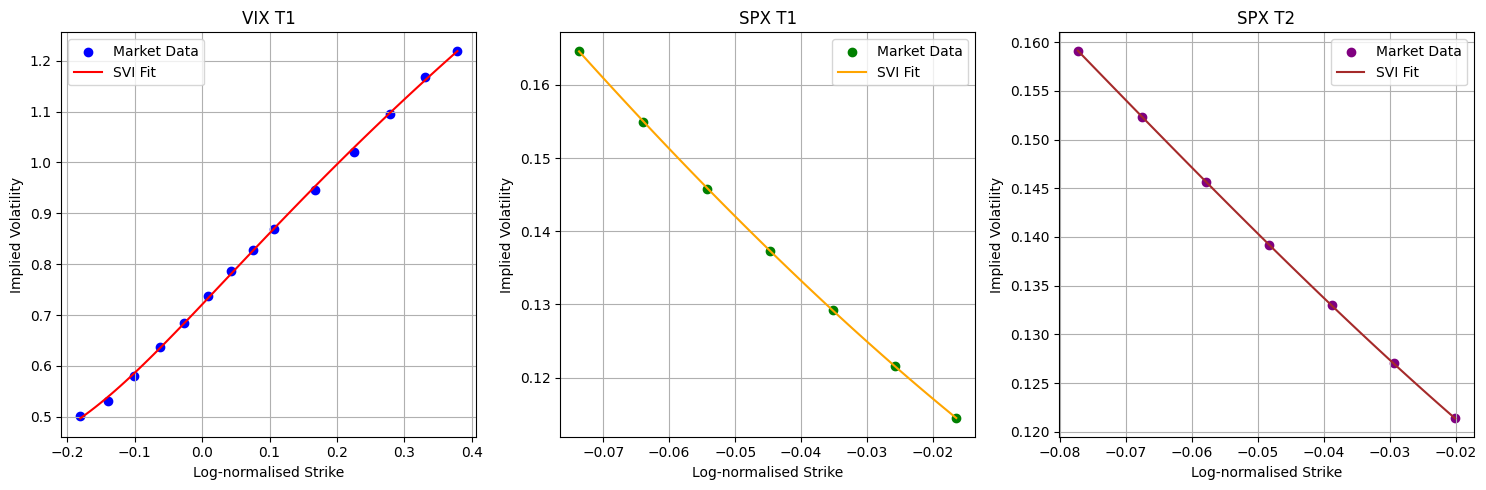

In [32]:
vopt=svi_lib.svi_fit(np.log(V_norm),V_market_vol,[0.01, 0.01, 0.01, 0.01, 0.01],T_V)
s1opt=svi_lib.svi_fit(np.log(S1_norm),S1_market_vol,[0.01, 0.01, 0.01, 0.01, 0.01],T1)
s2opt=svi_lib.svi_fit(np.log(S2_norm),S2_market_vol,[0.01, 0.01, 0.01, 0.01, 0.01],T2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
v_range = np.log(np.linspace(V_norm[0], V_norm[-1], 100))
s1_range = np.log(np.linspace(S1_norm[0], S1_norm[-1], 100))
s2_range = np.log(np.linspace(S2_norm[0], S2_norm[-1], 100))

ax1.scatter(np.log(V_norm), V_market_vol, color='blue', label='Market Data')
ax1.plot(v_range, svi_lib.svi_vol(v_range, vopt.x, T_V), color='red', label='SVI Fit')
ax1.set_xlabel('Log-normalised Strike')
ax1.set_ylabel('Implied Volatility')
ax1.set_title('VIX T1')
ax1.legend()
ax1.grid(True)

# Plot SPX T1
ax2.scatter(np.log(S1_norm), S1_market_vol, color='green', label='Market Data')
ax2.plot(s1_range, svi_lib.svi_vol(s1_range, s1opt.x, T1), color='orange', label='SVI Fit')
ax2.set_xlabel('Log-normalised Strike')
ax2.set_ylabel('Implied Volatility')
ax2.set_title('SPX T1')
ax2.legend()
ax2.grid(True)

# Plot SPX T2
ax3.scatter(np.log(S2_norm), S2_market_vol, color='purple', label='Market Data')
ax3.plot(s2_range, svi_lib.svi_vol(s2_range, s2opt.x, T2), color='brown', label='SVI Fit')
ax3.set_xlabel('Log-normalised Strike')
ax3.set_ylabel('Implied Volatility')
ax3.set_title('SPX T2')
ax3.legend()
ax3.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [33]:
def mu_s1(s):
    return svi_lib.SVIDensity(s,s1opt.x)

def mu_s2(s):
    return svi_lib.SVIDensity(s,s2opt.x)

def mu_v(v):
    return svi_lib.SVIDensity(v,vopt.x)

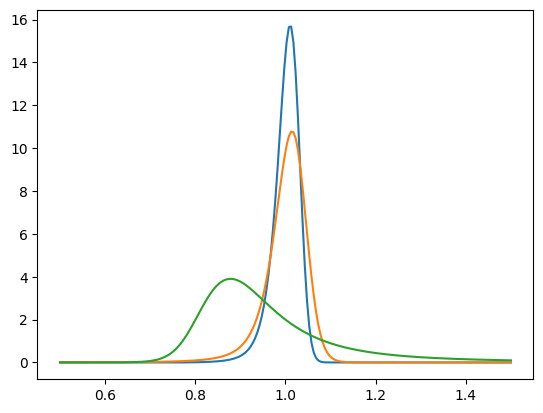

In [34]:
plt.plot(np.linspace(0.5,1.5,200),mu_s1(np.linspace(0.5,1.5,200)))
plt.plot(np.linspace(0.5,1.5,200),mu_s2(np.linspace(0.5,1.5,200)))
plt.plot(np.linspace(0.5,1.5,200),mu_v(np.linspace(0.5,1.5,200)))


## Pricing vol from SPX calls (martingale constrained LP)

In [35]:
#Forward Starter payoff
forw_starter = lambda s1,s2,k: np.maximum((s2 / s1) *(S2_forw / S1_forw) - k, 0)

#Vix payoff
def vix_call_payoff(S2, S1, K, tau):
    """
    VIX call payoff function on meshgrid S2, S1.
    V^2 = L(S2/S1), payoff = max(sqrt(L(S2/S1)) - K, 0)
    """
    r = np.clip((S2 / S1) * (S2_forw / S1_forw), 1e-8, None)
    L_val = -2.0 / tau * np.log(r)
    # Ensure L_val is non-negative before sqrt
    L_val = np.maximum(L_val, 0.0)
    vix_val = np.sqrt(L_val)
    return np.maximum(vix_val - K, 0)

In [ ]:
tau = T2 - T1
#call prices for SPX 1,2 and V (also normalised by the forw price for use in constraints)
C1 = np.array([bs_lib.black_scholes_call(S1_forw, K, T1, vol) for K,vol in zip(S1_strikes, S1_market_vol)])/S1_forw
C2 = np.array([bs_lib.black_scholes_call(S2_forw, K, T2, vol) for K,vol in zip(S2_strikes, S2_market_vol)])/S2_forw

grid_size = 100
s1_vals = np.linspace(0.75*min(S1_norm), 1.25*max(S1_norm), grid_size)
s2_vals = np.linspace(0.75*min(S2_norm), 1.25*max(S2_norm), grid_size)
S1, S2 = np.meshgrid(s1_vals, s2_vals, indexing='ij')

A_S1 = np.zeros((len(S1_norm), grid_size**2))
for k, K1 in enumerate(S1_norm):
    for i in range(grid_size):
        for j in range(grid_size):
            A_S1[k, i * grid_size + j] = max(s1_vals[i] - K1, 0)

A_S2 = np.zeros((len(S2_norm), grid_size**2))
for k, K2 in enumerate(S2_norm):
    for i in range(grid_size):
        for j in range(grid_size):
            A_S2[k, i * grid_size + j] = max(s2_vals[j] - K2, 0)

A_mart = np.zeros((grid_size, grid_size**2))
for i in range(grid_size):
    for j in range(grid_size):
        A_mart[i, i * grid_size + j] = s2_vals[j]*S2_forw - s1_vals[i]*S1_forw
b_mart = np.zeros(grid_size)

#normalisation requirement
A_norm = np.ones((1, grid_size**2))
b_norm = np.array([1.0])

A_eq = np.vstack([A_S1, A_S2, A_norm, A_mart])
b_eq = np.concatenate([C1, C2, b_norm, b_mart])
bounds = [(0, None)] * (grid_size**2)


payoff_grid = forw_starter(S1,S2,1.0)

payoff_flat = payoff_grid.flatten()

res_min = linprog(c=payoff_flat,A_eq=A_eq,b_eq=b_eq,bounds=bounds,method="highs")
min_price = res_min.fun if res_min.success else np.nan

res_max = linprog(c=-payoff_flat,A_eq=A_eq,b_eq=b_eq,bounds=bounds,method="highs")
max_price = -res_max.fun if res_max.success else np.nan

print(res_max.message)
print(res_min.message)


Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)


In [88]:
print(max_price)
print(min_price)

0.7186074366366693
0.08481601971065912
